## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'NIPA/a-yo-image'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NIPA/a-yo-image


In [ ]:
dataset = np.load('./initial-experiments/mongoose/data/data_run_offset_flip.npy')
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [ ]:
train_dataset.shape

(229, 10, 128, 128, 4)

In [ ]:

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (229, 9, 128, 128, 4), (229, 9, 128, 128, 4)
Validation Dataset Shapes: (26, 9, 128, 128, 4), (26, 9, 128, 128, 4)


## Data Visualization

Displaying frames for example 84.


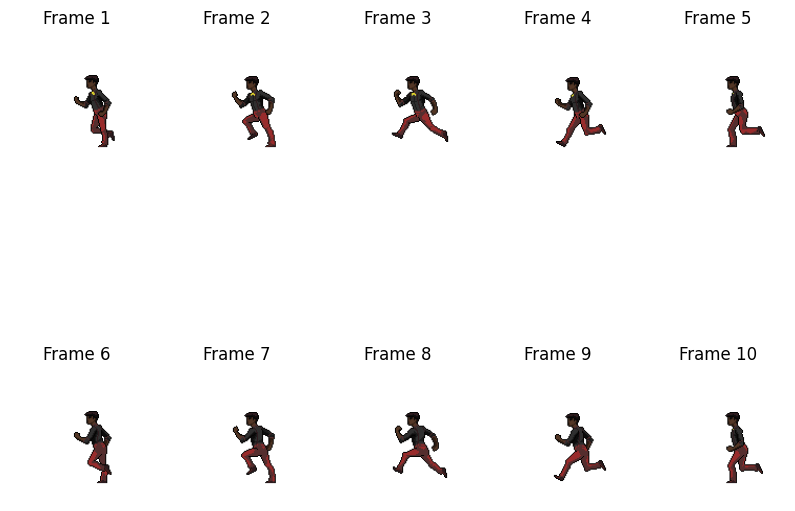

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=4, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 2000
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 0.2973 - val_loss: 0.4423 - learning_rate: 0.0010
Epoch 2/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 0.0513 - val_loss: 0.3168 - learning_rate: 0.0010
Epoch 3/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.0368 - val_loss: 0.2706 - learning_rate: 0.0010
Epoch 4/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0304 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 5/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.0263 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 6/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0253 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 7/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0241 - val_loss: 0.1228 - learning_rate: 0.0010
Epoch 8/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.0231 - val_loss: 0.1078 - learning_rate: 0.0010
Epoch 9/2000
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.0228 - val_loss: 0.0930 - learning_rate: 0.0010
Epoch 10/2

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


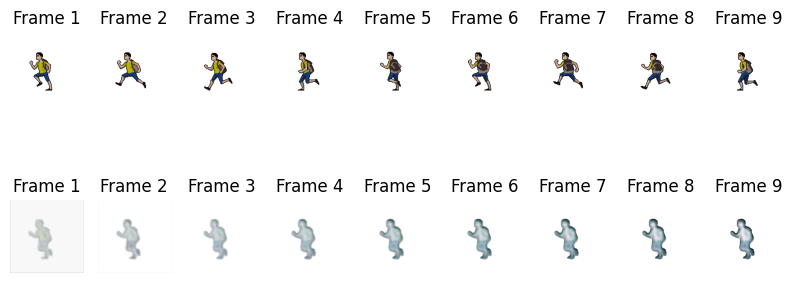

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:1, ...]
original_frames = example[1:, ...]

# Predict a new set of 10 frames.
for _ in range(9):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 9, figsize=(10, 4))
# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[1:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
new_frames[0][0]

array([[0.17135656, 0.27175424, 0.21377917, 0.24503252],
       [0.09194718, 0.1677247 , 0.12843613, 0.12881884],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 , 0.11260737, 0.10750885],
       [0.07978465, 0.1484632 ,

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


ValueError: need at least one array to stack

In [ ]:
# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)